In [7]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import math as mt
from tensorflow import keras
from tensorflow.keras import layers
import time
import wandb
import julia
from julia import DynamicalSystems
%load_ext julia.magic

physical_devices = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], True)

The julia.magic extension is already loaded. To reload it, use:
  %reload_ext julia.magic


In [43]:
%julia ds = DynamicalSystems.Systems.double_pendulum([π/2, 0., 0., 0.5]; G=10.0, L1 = 1.0, L2 = 1.0, M1 = 1.0, M2 = 1.0)
%julia q = DynamicalSystems.Systems.trajectory(ds, 1, dt = 0.01)[:,1];

In [51]:
%julia p = DynamicalSystems.Systems.trajectory(ds, 1, dt = 0.01)[:,2];

In [45]:
%julia qq = DynamicalSystems.Systems.trajectory(ds, 1, dt = 0.01)[:,3];

In [53]:
%julia pp = DynamicalSystems.Systems.trajectory(ds, 1, dt = 0.01)[:,4];

## given $\textbf{p}, \textbf{q} \in \mathbb{R}^{d}$ 

### $$\begin{equation}
\begin{aligned}
    \text{linear_module_up } : \mathcal{L}^{up}\begin{pmatrix}
    \textbf{p} \\
    \textbf{q}
    \end{pmatrix} &= \begin{pmatrix}
    I & S\\
    0 & I
    \end{pmatrix} \begin{pmatrix}
    \textbf{p} \\
    \textbf{q}
    \end{pmatrix} \\
    \text{linear_module_low } : \mathcal{L}^{low}\begin{pmatrix}
    \textbf{p} \\
    \textbf{q}
    \end{pmatrix} &= \begin{pmatrix}
    I & 0\\
    S & I
    \end{pmatrix} \begin{pmatrix}
    \textbf{p} \\
    \textbf{q}
    \end{pmatrix},
\end{aligned}
\end{equation}
$$

## where $S \in \mathbb{R}^{d \times d}$ is symmetric.

### $$\begin{equation}
\begin{aligned}
    \text{activation_module_up } : \mathcal{N}^{up}\begin{pmatrix}
    \textbf{p} \\
    \textbf{q}
    \end{pmatrix} &= \begin{bmatrix}
    I & \sigma_{\textbf{a}}\\
    0 & I
    \end{bmatrix} \begin{pmatrix}
    \textbf{p} \\
    \textbf{q}
    \end{pmatrix} := \begin{pmatrix}
    diag(\textbf{a})\sigma(\textbf{q}) + \textbf{p}\\
    \textbf{q}
    \end{pmatrix}\\
    \text{activation_module_low } : \mathcal{N}^{low}\begin{pmatrix}
    \textbf{p}\\
    \textbf{q}
    \end{pmatrix} &= \begin{bmatrix}
    I & 0 \\
    \sigma_{\textbf{a}} & I
    \end{bmatrix} \begin{pmatrix}
    \textbf{p} \\
    \textbf{q}
    \end{pmatrix} := \begin{pmatrix}
    \textbf{p} \\
    diag(\textbf{a})\sigma(\textbf{p}) + \textbf{q}
    \end{pmatrix},
\end{aligned}
\end{equation}
$$

## where $\sigma$ acts element-wise. The parameters are $S$ and $\textbf{a}$.

In [57]:
class linear_module_up(layers.Layer):
    
    def __init__(self, bias):
        
        super().__init__()
        self.w = self.add_weight(
        name='w',
        shape=(2,2),
        initializer = 'random_normal',
        trainable = True
        )
    
        if bias==1:
            self.b = self.add_weight(
            name='b',
            shape=(4,),
            initializer = 'random_normal',
            trainable = True
            )
            
        else:
            self.b = tf.constant([0., 0., 0., 0.])

    def call(self, x):
        
        L11 = tf.concat([[[1.,0.],[1.,1.]]], 0)
        L12 = self.w + tf.transpose(self.w)
        L21 = tf.concat([[[0.,0.],[0.,0.]]],0)
        L22 = tf.concat([[[1.,0.],[0.,1.]]],0)

        L = tf.concat([tf.concat([L11,L12], 1), tf.concat([L21,L22], 1)], 0)
        
        return tf.linalg.matvec(L,x) + self.b

class linear_module_low(layers.Layer):
    
    def __init__(self, bias):
        
        super().__init__()
        self.w = self.add_weight(
        name='w',
        shape=(2,2),
        initializer = 'random_normal',
        trainable = True
        )

        if bias==1:
            self.b = self.add_weight(
            name='b',
            shape=(4,),
            initializer = 'random_normal',
            trainable = True
            )
            
        else:
            self.b = tf.constant([0., 0., 0., 0.])

    def call(self, x):
        
        L11 = tf.concat([[[1.,0.],[1.,1.]]], 0)
        L12 = tf.concat([[[0.,0.],[0.,0.]]],0) 
        L21 = self.w + tf.transpose(self.w)
        L22 = tf.concat([[[1.,0.],[0.,1.]]],0)

        L = tf.concat([tf.concat([L11,L12], 1), tf.concat([L21,L22], 1)], 0)
        
        return tf.linalg.matvec(L,x) + self.b


class activation_module_up(layers.Layer):
    
    def __init__(self):
        
        super().__init__()
        self.w = self.add_weight(
        name='w',
        shape=(2,),
        initializer = 'random_normal',
        trainable = True
        )
        
    def tanh(self, x):
        
        return tf.where([True, True, False, False], tf.math.tanh(elem), elem)


    def call(self, x):        
        t = tf.concat([[[0.,0.,self.w[0], 0.]], [[0.,0.,0., self.w[1]]], [[0.,0.,0.,0.]], [[0.,0.,0.,0.]]], 0)
        
        return x + tf.linalg.matvec(t, tf.math.tanh(x))

class activation_module_low(layers.Layer):
    
    def __init__(self):
        
        super().__init__()
        self.w = self.add_weight(
        name='w',
        shape=(2,),
        initializer = 'random_normal',
        trainable = True
        )


    def call(self, x):
        t = tf.concat([[[0.,0.,0.,0.]], [[0.,0.,0.,0.]], [[self.w[0],0.,0.,0.]], [[0.,self.w[1],0.,0.]]],0)
        
        return x + tf.linalg.matvec(t, tf.math.tanh(x))

## $$\text{SympNet : } \phi = L_{1} L_{2} \dots L_{5} \text{  } A_{1} \text{  } L_{6} \dots L_{10} \text{  } A_{2} \dots $$

### A bias $\textbf{b} \in \mathbb{R}^{2d}$ is added at the end of every sequence of linear modules as:

## $$\begin{equation}
    \begin{pmatrix}
    I & 0/S_{n}\\
    S_{n}/0 & I
    \end{pmatrix} \dots \begin{pmatrix}
    I & 0 \\
    S_{2} & I
    \end{pmatrix} \begin{pmatrix}
    I & S_{1} \\
    0 & I
    \end{pmatrix} \begin{pmatrix}
    \textbf{q} \\
    \textbf{p}
    \end{pmatrix} + \textbf{b},
\end{equation}
$$

In [58]:
class SympNet(keras.Model):
    
    def __init__(self, N_layers, N_sub):
        
        super().__init__()
        
        
        self.Modules = []
        ind = [0]
        
        for i in range(N_layers):
            
            if i%2==0:
                self.Modules.append(activation_module_up())
                ind.append(ind[-1]+2)
                
            else:
                self.Modules.append(activation_module_low())
                ind.append(ind[-1]+2)
                
            for j in range(N_sub):
                
                if j==(N_sub-1):
                    bias = 1
                else:
                    bias = 0
                
                if j%2==0:
                    self.Modules.append(linear_module_up(bias))
                    ind.append(ind[-1]+3)

                else:
                    self.Modules.append(linear_module_low(bias))
                    ind.append(ind[-1]+3)
        
        

    def call(self, input_tensor):
        
        boom = self.Modules[0](input_tensor)
        
        for i in range(1,len(self.Modules)):
            boom = self.Modules[i](boom)
    
        return boom

### Training Dataset

In [64]:
q0 = [ 1.57079633,  1.57029008,  1.56877132,  1.56623999,  1.56269596,
        1.55813893,  1.55256841,  1.54598363,  1.53838346,  1.52976634,
        1.52013014,  1.50947214,  1.4977888 ,  1.48507566,  1.47132719,
        1.45653668,  1.44069587,  1.4237948 ,  1.40582162,  1.38676229,
        1.36660009,  1.34531526,  1.32288478,  1.29928185,  1.2744751 ,
        1.24842805,  1.22109889,  1.19243943,  1.16239451,  1.13090149,
        1.09789034,  1.06328288,  1.02699438,  0.98893652,  0.94902046,
        0.90716523,  0.86331409,  0.8174487 ,  0.76962074,  0.7199791 ,
        0.66879384,  0.6164605 ,  0.56347076,  0.51034823,  0.45757602,
        0.40553837,  0.35449726,  0.3045995 ,  0.25590153,  0.20839709,
        0.16204238,  0.11677371,  0.07252062,  0.029213  , -0.01321348,
       -0.05481512, -0.0956386 , -0.13572054, -0.17508728, -0.21375513,
       -0.25173069, -0.28901122, -0.32558532, -0.3614333 , -0.39652776,
       -0.43083439, -0.4643126 , -0.49691599, -0.52859308, -0.5592884 ,
       -0.58894304, -0.617495  , -0.64488027, -0.67103357, -0.69588896,
       -0.71938   , -0.74144064, -0.76200552, -0.78101026, -0.79839145,
       -0.8140869 , -0.82803549, -0.84017668, -0.85045043, -0.85879668,
       -0.86515466, -0.86946185, -0.87165371, -0.87166327, -0.8694197 ,
       -0.86484943, -0.85787699, -0.8484265 , -0.83642958, -0.82183374,
       -0.80461722, -0.78481867, -0.76256372, -0.7381067 , -0.71185326,
       -0.68435788]

q1 = [0.        ,  0.00500014,  0.01000213,  0.01501066,  0.02003348,
        0.02508141,  0.03016838,  0.03531141,  0.04053061,  0.04584924,
        0.0512937 ,  0.05689357,  0.06268166,  0.0686941 ,  0.07497036,
        0.08155333,  0.08848951,  0.0958291 ,  0.10362617,  0.11193878,
        0.12082942,  0.1303652 ,  0.14061811,  0.15166541,  0.16359027,
        0.17648227,  0.1904375 ,  0.20555958,  0.22196011,  0.23975858,
        0.25908225,  0.28006639,  0.30285128,  0.32757726,  0.35437976,
        0.3833763 ,  0.41464217,  0.44818959,  0.48392167,  0.52159315,
        0.56077611,  0.60085404,  0.64106433,  0.68059123,  0.71867083,
        0.7546768 ,  0.78815631,  0.81882258,  0.84652164,  0.87119466,
        0.89284325,  0.91150532,  0.9272371 ,  0.94010357,  0.95017144,
        0.95750643,  0.96217157,  0.96422716,  0.96373082,  0.96073846,
        0.95530483,  0.94748439,  0.93733224,  0.92490455,  0.91025917,
        0.89345604,  0.87455737,  0.85362761,  0.83073355,  0.80594367,
        0.77932793,  0.75095735,  0.72090321,  0.68923597,  0.65602448,
        0.62133555,  0.58523249,  0.5477739 ,  0.50901251,  0.46899482,
        0.42775947,  0.38533607,  0.34174367,  0.29699055,  0.25107267,
        0.20397244,  0.15565714,  0.10607848,  0.05517206,  0.00285545,
       -0.05097029, -0.10641961, -0.16362038, -0.22270348, -0.28379151,
       -0.34697891, -0.41229133, -0.47964893, -0.5488079 , -0.61932683,
       -0.69056598]

p0 = [ 0.        , -0.10125017, -0.20250277, -0.30376435, -0.40504662,
       -0.506367  , -0.60774955, -0.70922559, -0.8108346 , -0.91262551,
       -1.01465761, -1.11700168, -1.21974179, -1.32297743, -1.42682445,
       -1.5314175 , -1.63691353, -1.74349452, -1.85136943, -1.96077819,
       -2.07199781, -2.18534634, -2.30118552, -2.41992759, -2.54204159,
       -2.66805866, -2.79857152, -2.93424261, -3.07579153, -3.22397474,
       -3.37957252, -3.54333122, -3.71582254, -3.89727009, -4.08733168,
       -4.28461447, -4.48601954, -4.6862167 , -4.87691111, -5.04695915,
       -5.18347492, -5.27486859, -5.31425196, -5.30209376, -5.24589777,
       -5.1572809 , -5.04853954, -4.93011271, -4.80963302, -4.69201042,
       -4.58001814, -4.47489426, -4.37690681, -4.28569241, -4.20054534,
       -4.12056114, -4.04474674, -3.97207936, -3.90154007, -3.83213893,
       -3.76292489, -3.69299393, -3.62149585, -3.5476373 , -3.47068507,
       -3.38997024, -3.30489148, -3.21491645, -3.11958479, -3.01850896,
       -2.91137454, -2.79793902, -2.67803075, -2.55154175, -2.41842244,
       -2.27867837, -2.13235948, -1.97954777, -1.82034327, -1.65486067,
       -1.48321099, -1.30548845, -1.12174937, -0.93201006, -0.73623171,
       -0.53430534, -0.32605193, -0.11122117,  0.11049549,  0.33943942,
        0.57587671,  0.81991338,  1.07130201,  1.32897823,  1.59063933,
        1.85198809,  2.10573597,  2.34104379,  2.54362084,  2.69773683,
        2.79030685]

p1 = [0.5       ,  0.50005438,  0.50042258,  0.50141222,  0.50333116,
        0.50648764,  0.51119064,  0.51775023,  0.52647793,  0.53768766,
        0.55169624,  0.56882427,  0.58939738,  0.61374811,  0.64221673,
        0.67515316,  0.71292041,  0.75589722,  0.80448007,  0.85908686,
        0.92016352,  0.98818821,  1.06367406,  1.14717629,  1.23929817,
        1.34069595,  1.45207699,  1.57420714,  1.7078881 ,  1.85392227,
        2.01309262,  2.18607211,  2.37321465,  2.57430031,  2.78822002,
        3.01227592,  3.24124806,  3.46665028,  3.6757013 ,  3.85152402,
        3.97475548,  4.02793096,  4.00038602,  3.89210292,  3.71330854,
        3.48035455,  3.21082902,  2.91991408,  2.61898462,  2.31568097,
        2.01470459,  1.71865193,  1.42880438,  1.14560517,  0.86906782,
        0.59897928,  0.33505512,  0.07701915, -0.17535295, -0.42220868,
       -0.66361387, -0.89955298, -1.1299418 , -1.35463547, -1.57344258,
       -1.78614481, -1.99251379, -2.19232138, -2.38535834, -2.57145602,
       -2.75049668, -2.92242033, -3.08724401, -3.24507067, -3.39609715,
       -3.54061632, -3.67902661, -3.81183406, -3.93965504, -4.06321669,
       -4.18335856, -4.30103279, -4.41730636, -4.53336113, -4.65049414,
       -4.77011962, -4.89375692, -5.02302806, -5.15963671, -5.3053254 ,
       -5.46173785, -5.6303068 , -5.81199923, -6.00669371, -6.21260664,
       -6.42525504, -6.6360468 , -6.8314528 , -6.99302198, -7.09998891,
       -7.13474161]

X = []
for i in zip(p0, p1, q0, q1):
    X.append([[i[0],i[1],i[2],i[3]]])

x_train = np.array(X[:len(X)-1])
x_train = x_train.astype(np.float32)

y_train = np.array(X[1:])
y_train = y_train.astype(np.float32)

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))

train_dataset = train_dataset.batch(101)

train_dataset.element_spec

(TensorSpec(shape=(None, 1, 4), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 4), dtype=tf.float32, name=None))

# Model + training

### Given a single trajectory in the phase-space 

## $$\mathcal{O}_{true} = \{(\textbf{p}_{i}, \textbf{q}_{i})\}_{i=1}^{N},$$

### the training set is of the form:

## $$ \mathcal{T} = \{ (\textbf{p}_{i}, \textbf{q}_{i}), (\textbf{p}_{i+1}, \textbf{q}_{i+1})\}_{i=1}^{N-1}$$

### The prediction is made by iterating the trained SympNet from a starting point

## $$ \mathcal{O}_{predicted} = \{(\textbf{p}_{0}, \textbf{q}_{0}), \phi(\textbf{p}_{0}, \textbf{q}_{0}), \phi(\phi(\textbf{p}_{0}, \textbf{q}_{0})), \dots \}$$


In [73]:
model = SympNet(8, 5)

In [74]:
model.compile(
    loss= tf.keras.losses.MeanSquaredError(),
    optimizer=keras.optimizers.Adam(), #clipvalue = 0.001),
    #optimizer=keras.optimizers.SGD(0.00001), #, clipvalue = 0.001),
    metrics=["accuracy"],
)

In [81]:
#wandb.init()

start_time = time.time()
history = model.fit(train_dataset, epochs=300, verbose=0)
print("running time : %s seconds" % (time.time() - start_time))

running time : 6.098762273788452 seconds


### Plot the loss

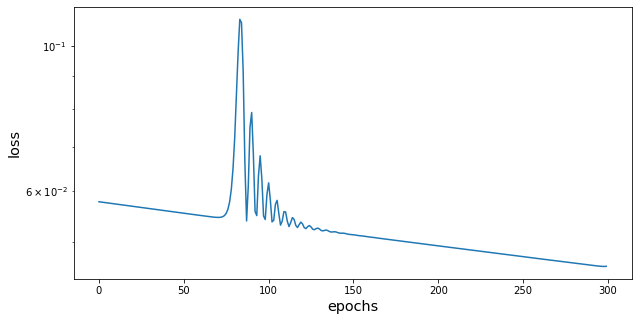

In [82]:
plt.figure(figsize = (10,5))
plt.plot(history.history["loss"])
plt.xlabel("epochs", fontsize = "x-large")
plt.ylabel("loss", fontsize = "x-large")
plt.yscale("log")

#plt.savefig("DP_loss_adam_bs1_epochs1000_clipping0001")

### Plot the result

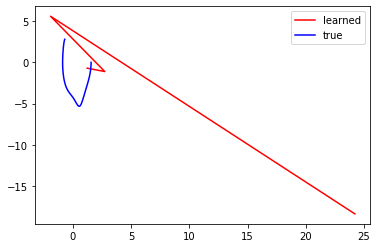

In [80]:
N_test = 3

p = [model(x_train[0][0])[0]]
pp = [model(x_train[0][0])[1]]

q = [model(x_train[0][0])[2]]
qq = [model(x_train[0][0])[3]]

run = [model(X[0][0])]

for i in range(N_test):
    run.append(model(run[-1]))
    p.append(run[-1][0])
    pp.append(run[-1][1])
    q.append(run[-1][2])
    qq.append(run[-1][3])


plt.plot(q, p, color = "r", label = "learned")
plt.plot(q0, p0, color = "b", label = "true")
plt.legend()
plt.show()